# Baseline model for batch monitoring example

In [3]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [4]:
files = [('green_tripdata_2024-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:09<00:00, 138165.81it/s, save to ./data/green_tripdata_2024-03.parquet]


In [5]:
mar_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [6]:
mar_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405399,2024-03-16 04:21:00.076039,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [7]:
mar_data.shape

(57457, 20)

In [8]:
# create target
mar_data["duration_min"] = mar_data.lpep_dropoff_datetime - mar_data.lpep_pickup_datetime
mar_data.duration_min = mar_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [9]:
# filter out outliers
mar_data = mar_data[(mar_data.duration_min >= 0) & (mar_data.duration_min <= 60)]
mar_data = mar_data[(mar_data.passenger_count > 0) & (mar_data.passenger_count <= 8)]

<Axes: >

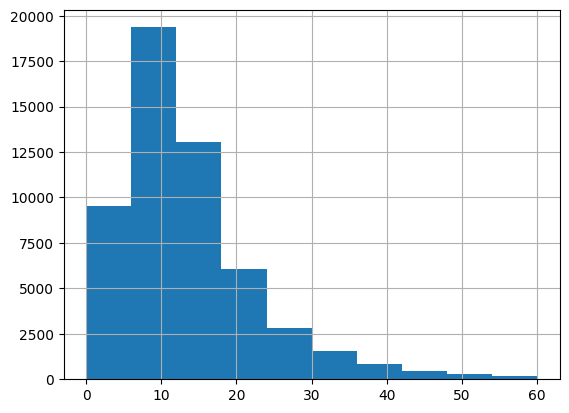

In [10]:
mar_data.duration_min.hist()

In [11]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [12]:
mar_data.shape

(54135, 21)

# Evidently Report

In [13]:
column_mapping = ColumnMapping(
    target=None,
    numerical_features=num_features,
    categorical_features=cat_features
)

In [14]:
maxFare = float('-inf')
for i in range(1,31):
    regular_report = Report(
        metrics=[
            ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    
    # regular_report
    result = regular_report.as_dict()
    print(result['metrics'][0]['result']['current']['value'])
    maxFare = max(maxFare,result['metrics'][0]['result']['current']['value'])

print(maxFare)

13.5
12.8
14.2
12.8
12.8
12.8
13.5
12.8
13.5
14.2
12.8
12.8
13.5
14.2
13.5
13.5
13.5
12.8
13.5
12.8
13.5
12.8
12.8
14.015
13.5
13.5
12.8
13.25
12.8
14.0
14.2


# Evidently Dashboard

In [15]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [16]:
ws = Workspace("workspace")

In [17]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project descriotion"
project.save()

Project(id=UUID('9f47a336-c332-41bd-a14a-ca22d49c7940'), name='NYC Taxi Data Quality Project', description='My project descriotion', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 22, 15, 27, 21, 581399))

In [19]:
maxFare = float('-inf')
for i in range(1,31):
    regular_report = Report(
        metrics=[
            ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    ws.add_report(project.id, regular_report)
    # regular_report
    result = regular_report.as_dict()
    print(result['metrics'][0]['result']['current']['value'])
    maxFare = max(maxFare,result['metrics'][0]['result']['current']['value'])

print(maxFare)

13.5
12.8
14.2
12.8
12.8
12.8
13.5
12.8
13.5
14.2
12.8
12.8
13.5
14.2
13.5
13.5
13.5
12.8
13.5
12.8
13.5
12.8
12.8
14.015
13.5
13.5
12.8
13.25
12.8
14.0
14.2


In [21]:

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="50th Quantile of Fare Amount",
        values=[
            PanelValue(
                metric_id="fare_amount_quantile_50th",
                field_path="current.fare_amount",
                legend="50th Quantile"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('9f47a336-c332-41bd-a14a-ca22d49c7940'), name='NYC Taxi Data Quality Project', description='My project descriotion', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('f8044fb2-b726-41b5-8d76-c9224e89225c'), title='50th Quantile', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.', metric_id='', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.LINE: 'line'>), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('fdae8fbe-c119-4fca-8322-8881859920da'), title='50th Quantile of Fare Amount', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.fare_amount', metric_id='fare_amount_quantile_50th', metric_fingerprin

In [22]:
ws.add_report(project.id, regular_report)